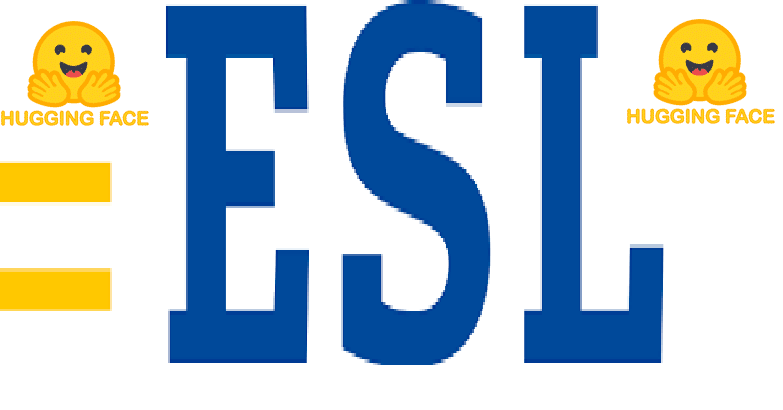

**The goal of this project is to assess the language proficiency of 8th-12th grade English Language Learners. Utilizing a dataset of essays written by ELLs will help to develop proficiency models that better supports all students.**

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Config

In [2]:
# ====================================================
# Config
# ====================================================
class CFG:
    wandb=True
    competition='FB3'
    _wandb_kernel='skytoin'
    debug=False
    apex=True
    print_freq=160
    num_workers=4
    model="microsoft/deberta-v3-large"
    gradient_checkpointing=True
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=6
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=2
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1300#1000
    target_cols=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    seed=42
    n_fold=10
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='FB3-large8', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train8",
                     anonymous=anony)

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

os.system('pip install iterative-stratification==0.1.7')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Found existing installation: transformers 4.20.1
Uninstalling transformers-4.20.1:
  Successfully uninstalled transformers-4.20.1


Found existing installation: tokenizers 0.12.1
Uninstalling tokenizers-0.12.1:
  Successfully uninstalled tokenizers-0.12.1


Looking in links: ../input/fb3-pip-wheels
Processing /kaggle/input/fb3-pip-wheels/transformers-4.21.2-py3-none-any.whl
Processing /kaggle/input/fb3-pip-wheels/tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 4.21.2 which is incompatible.


Looking in links: ../input/fb3-pip-wheels


tokenizers.__version__: 0.12.1
transformers.__version__: 4.21.2
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
submission = pd.read_csv('../input/feedback-prize-english-language-learning/sample_submission.csv')

print(f"train.shape: {train.shape}")
display(train.head())
print(f"test.shape: {test.shape}")
display(test.head())
print(f"submission.shape: {submission.shape}")
display(submission.head())

train.shape: (3911, 8)


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


test.shape: (3, 2)


,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


submission.shape: (3, 7)


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


In [7]:
from typing import Dict, List, Tuple
import codecs
from text_unidecode import unidecode
import collections

In [8]:
def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

In [9]:
train['full_text'] = train['full_text'].apply(resolve_encodings_and_normalize)
test['full_text'] = test['full_text'].apply(resolve_encodings_and_normalize)

# EDA

In [10]:
import plotly.express as px

# Number of words per essay distribution

train['split_text'] = train['full_text'].str.split(pat=None, n=-1, expand=False).str.len()

fig = px.histogram(train, x = train['split_text'], marginal = 'box', 
                   title = 'Historgram of Full Text', color_discrete_sequence =["#FFA200"])

fig.update_layout(bargap = 0.2)
fig.update_layout(template = 'plotly_dark', font = dict(family = 'PT Sans', size = 19, color = "#C4FEFF"))

fig.show()

In [11]:
# Distribution of scores per each category

colors = [["#00E600"], ["#0000E6"], ["#E600DF"], ["#E6E600"], ["#FFFFFF"], ["#cd040b"]]


for count, x in enumerate(["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]):
    fig = px.histogram(train, x = x, marginal = 'violin', title = f" {x} histogram", color_discrete_sequence = colors[count]  )
    
    fig.update_layout(bargap = 0.2)
    fig.update_layout(template = 'plotly_dark', font = dict(family = 'PT Sans', size = 19, color = "#C4FEFF" ) )
    
    fig.show() 
    

<AxesSubplot:>

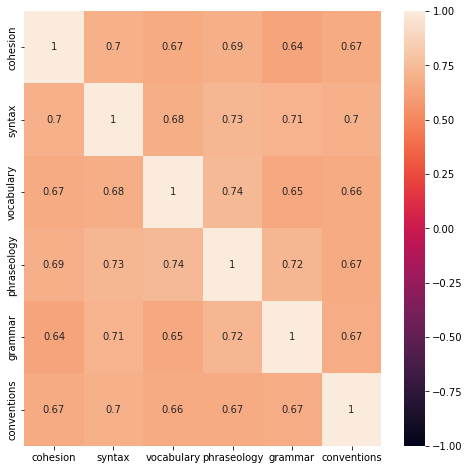

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Six categories score correlation table


plt.figure(figsize=(8, 8))


cor_matrix = train[CFG.target_cols]

sns.heatmap(cor_matrix.corr(), vmin=-1, vmax=1, annot=True)

In [13]:
!pip install language-tool-python

import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

In [14]:
categories = ['CONFUSED_WORDS','PUNCTUATION','TYPOS','TYPOGRAPHY','GRAMMAR',
              'COLLOCATIONS','COMPOUNDING', 'MISC','STYLE','CASING','BRITISH_ENGLISH',
              'REDUNDANCY''AMERICAN_ENGLISH_STYLE','NONSTANDARD_PHRASES']

In [15]:
# from tqdm.notebook import tqdm
# tqdm.pandas()



# def building_list_of_errors_per_student(row):
#     # checking text for erros and collecting
#     # them for each student

#     txt = row['full_text']
#     matches = tool.check(txt)

#     list_of_errors = []

#     for mat in matches:
#         list_of_errors.append(mat.category)


#     # --------------------------------- second part
#     # building list of error ids for each student

#     mistakez = []

#     freq = collections.Counter(list_of_errors)

#     for id in categories:
#         if id not in freq:
#             mistakez.append(0)

#         else:
#             mistakez.append(freq[id])


#     return mistakez




# train['list_of_errors'] = train[['full_text']].progress_apply(
#     building_list_of_errors_per_student, axis=1
# )

In [16]:
# train['list_of_errors_string'] = train['list_of_errors'].astype(str)
#train['full_text'] = train['list_of_errors_string'].str[1:-1] + '   ' + train['full_text']


# train[categories] = pd.DataFrame(train.list_of_errors.tolist(), 
#                                      index= train.index)

# CV split

In [17]:

# ====================================================
# CV split
# ====================================================
Fold = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_cols])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    391
1    391
2    391
3    391
4    391
5    391
6    391
7    391
8    391
9    392
dtype: int64

In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:


# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer
    
# else:
#     tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/vopolh-deberta-3-large-model/tokenizer')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
# txt = "The Higgs field gives mass to subatomic particles"

# print(tokenizer(txt))
# tokenizer.tokenize(txt)

# Dataset

In [21]:
# ====================================================
# Define max_len
# ====================================================
lengths = []
tk0 = tqdm(train['full_text'].fillna("").values, total=len(train))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
CFG.max_len = max(lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/3911 [00:00<?, ?it/s]

max_len: 1429


In [22]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=CFG.max_len,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['full_text'].values
        self.labels = df[cfg.target_cols].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label
    

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# Model

In [23]:
class LSTMBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers=1, p_drop=0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_channels,
                             hidden_size=out_channels,
                             num_layers=num_layers,
                             dropout=p_drop,
                             batch_first=True, 
                             bidirectional=True)
    def forward(self, x):
        x,_ = self.lstm(x)
        return x

In [24]:
class AttentionPool(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionPool, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, 1),
        )
        
        
    def forward(self, hidden_state, attention_mask):
        w = self.attention(hidden_state)
        w[attention_mask == 0] = float("-inf")
        w = torch.softmax(w, dim=1)
        context = torch.sum(hidden_state * w, dim=1)
        return context

In [25]:
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    

class LangScoreModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
        #self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size * 4, 6)
        self._init_weights(self.fc)
        self.lstm_ = LSTMBlock(1024 * 4, 1024 * 2)
        
        self.pool =  AttentionPool(1024 * 4)
        
    def _init_weights(self, module):
        
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs, output_hidden_states=True).hidden_states
        #outputs = self.model(**inputs)
        #last_hidden_states = outputs
        
        last_hidden_states = torch.cat(outputs[-4:], dim=-1)
        sub_out = self.lstm_(last_hidden_states)
        feature = self.pool(sub_out, inputs['attention_mask'])
        
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output

# Loss

In [26]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, reduction='mean', eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss

# Helpler functions

In [27]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# train loop

In [28]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = LangScoreModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.SmoothL1Loss(reduction='mean') # RMSELoss(reduction="mean")
    
    best_score = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score, scores = get_score(valid_labels, predictions)
        

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {scores}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score > score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [29]:
train_model = False

if train_model:

    if __name__ == '__main__':

        def get_result(oof_df):
            labels = oof_df[CFG.target_cols].values
            preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
            score, scores = get_score(labels, preds)
            LOGGER.info(f'Score: {score:<.4f}  Scores: {scores}')

        if CFG.train:
            oof_df = pd.DataFrame()
            for fold in range(1):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(train, fold)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} result ==========")
                    get_result(_oof_df)
            oof_df = oof_df.reset_index(drop=True)
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)
            oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')

        if CFG.wandb:
            wandb.finish()

In [30]:
# torch.cuda.empty_cache()
# gc.collect()

In [31]:
#loading trained model

checkpoint = torch.load('/kaggle/input/deberta-3-large-trained/microsoft-deberta-v3-large_fold0_best (1).pth')
model = LangScoreModel(CFG, config_path=None, pretrained=True)    
model.load_state_dict(checkpoint['model'])

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.21.2",
  "type_vocab_size": 0,
  "vocab_size": 128100
}



Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [32]:
test_ = pd.concat([test, submission[CFG.target_cols]], sort=False, axis = 1)



#train_dataset = TrainDataset(CFG, test_folds)
#valid_dataset = TrainDataset(CFG, valid_folds)
test_dataset = TrainDataset(CFG, test_)

In [33]:
# train_loader = DataLoader(test_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

# valid_loader = DataLoader(valid_dataset,
#                           batch_size=CFG.batch_size * 2,
#                           shuffle=False,
#                           num_workers=CFG.num_workers, pin_memory=True, drop_last=False)



test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size * 2,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

In [34]:
criterion = nn.SmoothL1Loss(reduction='mean')

In [35]:
device = "cuda" #if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model.to(device)

Using cuda device


LangScoreModel(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
            

In [36]:
avg_val_loss, predictions = valid_fn(test_loader, model, criterion, device)

EVAL: [0/1] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1102(0.1102) 


In [37]:
predictions

array([[3.0273483, 2.7972655, 3.1536798, 3.0342345, 2.705814 , 2.683408 ],
       [2.546533 , 2.4206705, 2.605228 , 2.3004324, 2.102575 , 2.6244378],
       [3.5978117, 3.4187946, 3.5786226, 3.6180606, 3.5080438, 3.2714727]],
      dtype=float32)

In [38]:
test_[CFG.target_cols] = predictions.clip(1, 5)
test_.to_csv('submission.csv', index=False)